# Analyze the two population model

## Set up

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "pirnns"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/pirnns/pirnns
Directory added to path:  /home/facosta/pirnns
Directory added to path:  /home/facosta/pirnns/pirnns


## Load the trained model

In [2]:
import torch
import yaml

from pirnns.rnns.rnn import RNN, RNNLightning
from pirnns.rnns.coupled_rnn import CoupledRNN, CoupledRNNLightning
import torch.nn as nn
import glob

model_type = "coupled"  # or "coupled" depending on your run
run_id = "20250821_234558"  # Update this to your actual run ID


run_dir = f"logs/checkpoints/{model_type}_{run_id}"
config_path = f"{run_dir}/config_{run_id}.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

checkpoint_files = glob.glob(f"{run_dir}/best-model-*.ckpt")
print(f"Loading Lightning checkpoint from: {checkpoint_files[0]}")

# Create the correct model based on type
if model_type == "vanilla":
    model = RNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["num_place_cells"],  # Updated parameter name
        alpha=config["alpha"],
        activation=getattr(nn, config["activation"]),
    )

    rnn_lightning = RNNLightning.load_from_checkpoint(
        checkpoint_files[0],
        model=model,
        learning_rate=config["learning_rate"],
        weight_decay=config["weight_decay"],
        step_size=config["step_size"],
        gamma=config["gamma"],
    )
elif model_type == "coupled":
    model = CoupledRNN(
        input_size=config["input_size"],
        pop1_size=config["pop1_size"],
        pop2_size=config["pop2_size"],
        output_size=config["num_place_cells"],
        alpha1=config["alpha1"],
        alpha2=config["alpha2"],
        activation=getattr(nn, config["activation"]),
        output_from=config["output_from"],
    )

    rnn_lightning = CoupledRNNLightning.load_from_checkpoint(
        checkpoint_files[0],
        model=model,
        learning_rate=config["learning_rate"],
        weight_decay=config["weight_decay"],
        step_size=config["step_size"],
        gamma=config["gamma"],
    )

model = rnn_lightning.model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print(f"Loaded model from run: {run_id}")
print(f"Model config: {config_path}")
print(f"Device: {device}")

Loading Lightning checkpoint from: logs/checkpoints/coupled_20250821_234558/best-model-epoch=96-val_loss=6.052.ckpt
Loaded model from run: 20250821_234558
Model config: logs/checkpoints/coupled_20250821_234558/config_20250821_234558.yaml
Device: cuda


## Visualize the loss curves

Loaded loss data from: logs/checkpoints/coupled_20250821_234558/training_losses.json
Training epochs: 99


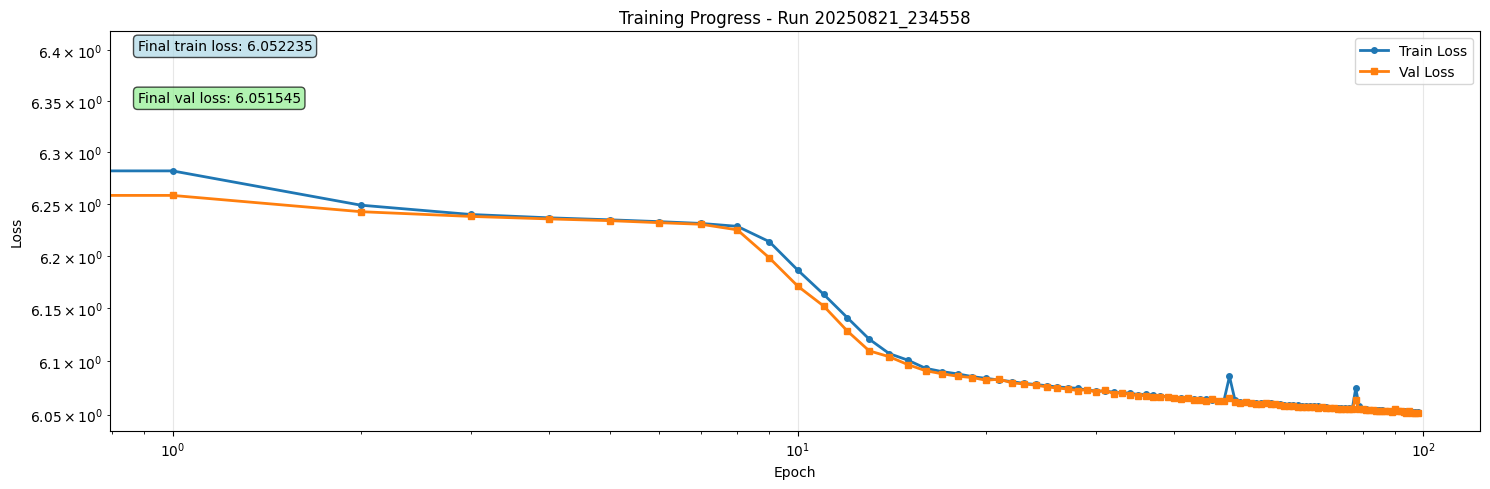

Initial train loss: 6.4009
Final train loss: 6.0522
Initial val loss: 6.3178
Final val loss: 6.0515
Best val loss: 6.051512 at epoch 96


In [3]:
from pirnns.analysis import plot_loss_curves

plot_loss_curves(
    loss_file=f"{run_dir}/training_losses.json",
    title=f"Training Progress - Run {run_id}",
    log_x=True,
    log_y=True,
)

## Load evaluation datamodule

In [4]:
from datamodule import PathIntegrationDataModule

num_trajectories = 10000
batch_size = 1

eval_datamodule = PathIntegrationDataModule(
    num_trajectories=num_trajectories,
    batch_size=batch_size,
    num_workers=1,
    train_val_split=0.0,
    velocity_representation=config["velocity_representation"],
    dt=config["dt"],
    num_time_steps=config["num_time_steps"],
    arena_size=config["arena_size"],  # Changed from arena_L
    speed_scale=config["speed_scale"],  # Changed from mu_speed
    sigma_speed=config["sigma_speed"],
    tau_vel=config["tau_vel"],
    sigma_rotation=config["sigma_rotation"],
    border_region=config["border_region"],
    num_place_cells=config["num_place_cells"],
    place_cell_rf=config["place_cell_rf"],
    surround_scale=config["surround_scale"],
    DoG=config["DoG"],
    trajectory_type=config["trajectory_type"],
    place_cell_layout=config["place_cell_layout"],
)

eval_datamodule.setup()

eval_loader = eval_datamodule.val_dataloader()

print(f"Number of validation batches: {len(eval_loader)}")
print(f"Validation dataset size: {len(eval_datamodule.val_dataset)}")

Number of validation batches: 10000
Validation dataset size: 10000


## Visualize hidden unit activations over space

Computing spatial rate maps using 10000 trajectories...
Spatial grid: 44 x 44 bins of size 0.05
Hidden units to analyze: 4096
Processed 1/10000 trajectories...
Processed 51/10000 trajectories...
Processed 101/10000 trajectories...
Processed 151/10000 trajectories...
Processed 201/10000 trajectories...
Processed 251/10000 trajectories...
Processed 301/10000 trajectories...
Processed 351/10000 trajectories...
Processed 401/10000 trajectories...
Processed 451/10000 trajectories...
Processed 501/10000 trajectories...
Processed 551/10000 trajectories...
Processed 601/10000 trajectories...
Processed 651/10000 trajectories...
Processed 701/10000 trajectories...
Processed 751/10000 trajectories...
Processed 801/10000 trajectories...
Processed 851/10000 trajectories...
Processed 901/10000 trajectories...
Processed 951/10000 trajectories...
Processed 1001/10000 trajectories...
Processed 1051/10000 trajectories...
Processed 1101/10000 trajectories...
Processed 1151/10000 trajectories...
Processed

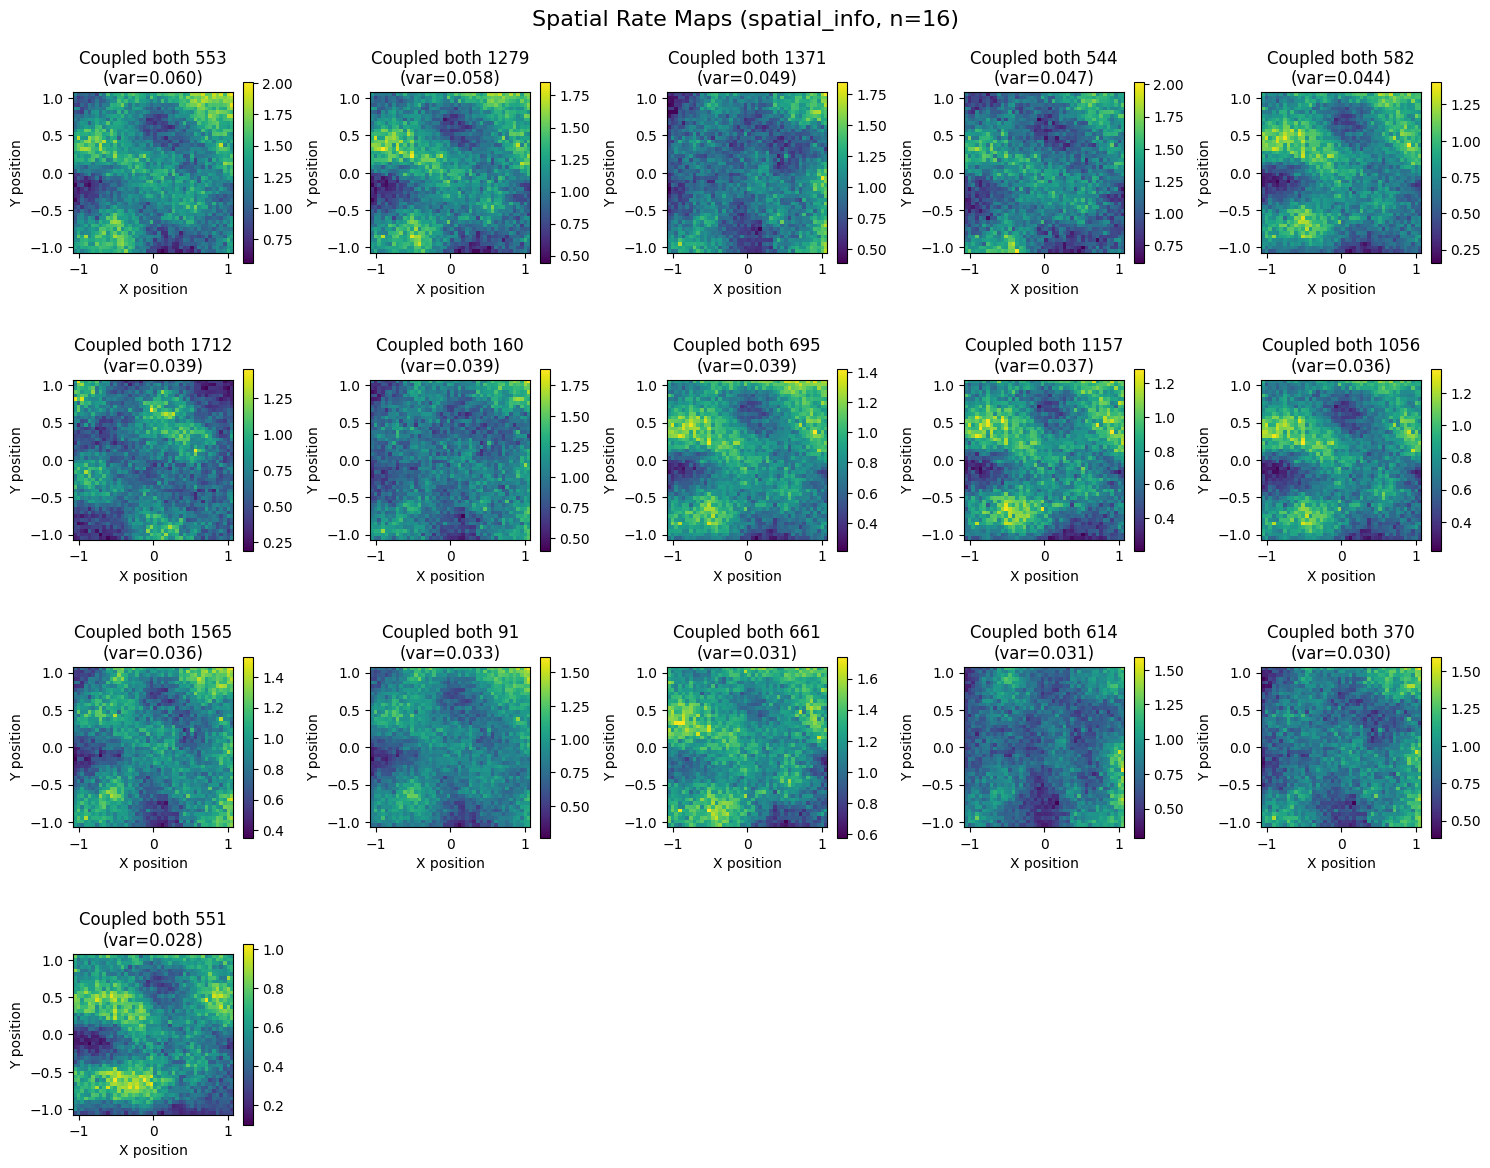

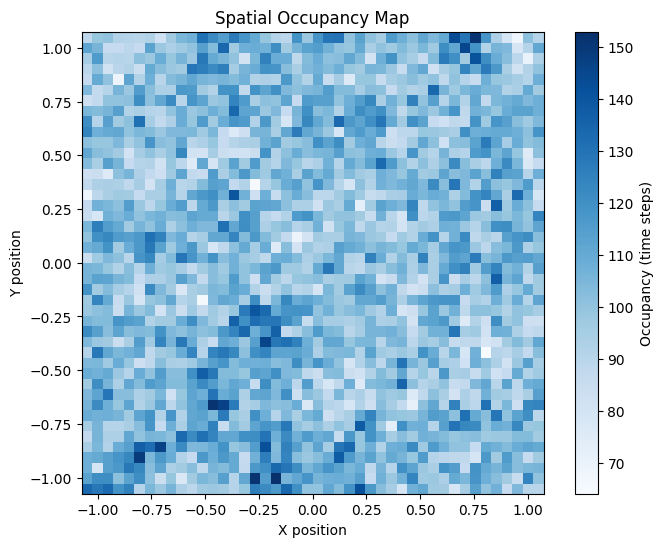

In [6]:
from pirnns.analysis.spatial import SpatialAnalyzer

spatial = SpatialAnalyzer(
    model=model,
    device=device,
    model_type=model_type,
    population_to_visualize="both",
)

spatial.compute_rate_maps(
    eval_loader=eval_loader,
    arena_size=config["arena_size"],
    bin_size=0.05,
    num_trajectories=10000,
    min_occupancy=10,
).plot_rate_maps(num_units=16, selection_method="random").plot_occupancy_map();

Computing spatial rate maps using 10000 trajectories...
Spatial grid: 44 x 44 bins of size 0.05
Hidden units to analyze: 4096
Processed 1/10000 trajectories...
Processed 51/10000 trajectories...
Processed 101/10000 trajectories...
Processed 151/10000 trajectories...
Processed 201/10000 trajectories...
Processed 251/10000 trajectories...
Processed 301/10000 trajectories...
Processed 351/10000 trajectories...
Processed 401/10000 trajectories...
Processed 451/10000 trajectories...
Processed 501/10000 trajectories...
Processed 551/10000 trajectories...
Processed 601/10000 trajectories...
Processed 651/10000 trajectories...
Processed 701/10000 trajectories...
Processed 751/10000 trajectories...
Processed 801/10000 trajectories...
Processed 851/10000 trajectories...
Processed 901/10000 trajectories...
Processed 951/10000 trajectories...
Processed 1001/10000 trajectories...
Processed 1051/10000 trajectories...
Processed 1101/10000 trajectories...
Processed 1151/10000 trajectories...
Processed

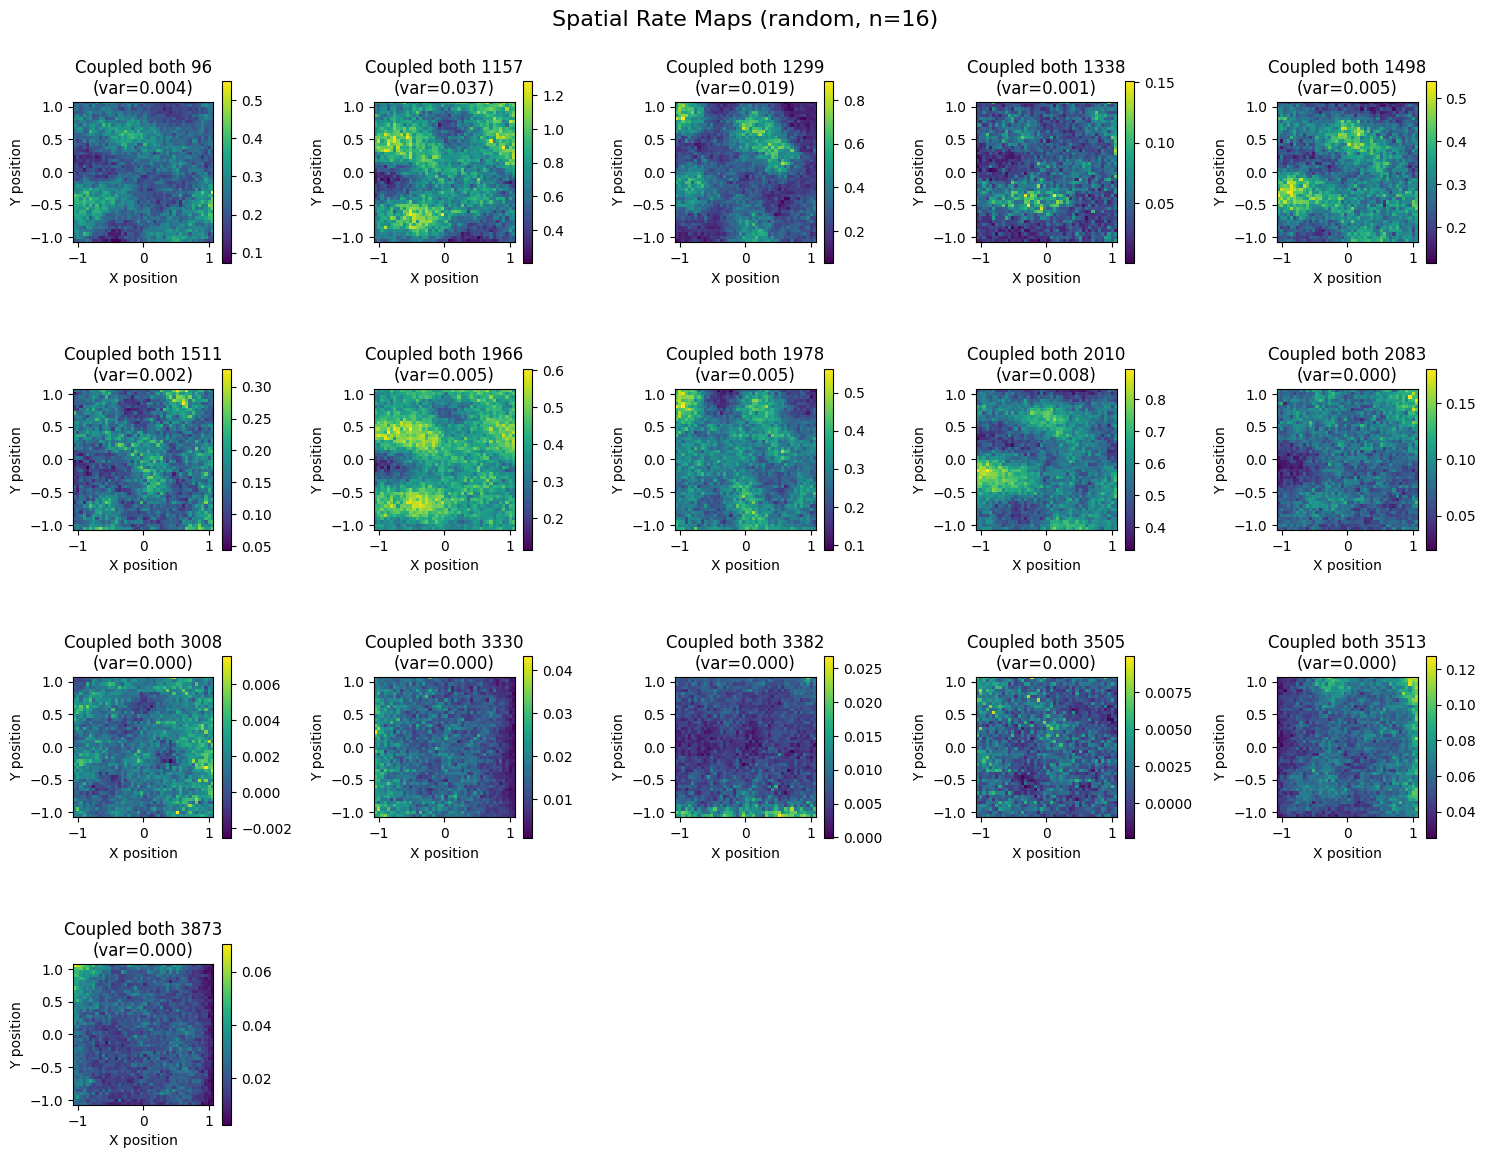

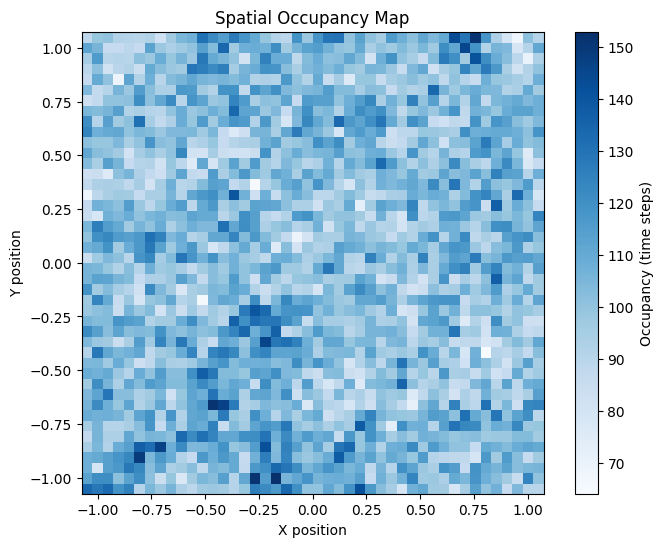

In [7]:
spatial.compute_rate_maps(
    eval_loader=eval_loader,
    arena_size=config["arena_size"],
    bin_size=0.05,
    num_trajectories=10000,
    min_occupancy=10,
).plot_rate_maps(num_units=16, selection_method="random").plot_occupancy_map();

## Principal Component Analysis

Compare with untrained model.

Computing hidden states from 1000 batches...
Processed batch 1/1000
Processed batch 101/1000
Processed batch 201/1000
Processed batch 301/1000
Processed batch 401/1000
Processed batch 501/1000
Processed batch 601/1000
Processed batch 701/1000
Processed batch 801/1000
Processed batch 901/1000
Hidden states computed:
  Trained shape: torch.Size([1000, 20, 2048])
  Untrained shape: torch.Size([1000, 20, 2048])
Computing PCA with 100 components...
Data shapes for PCA:
  Trained: torch.Size([20000, 2048])
  Untrained: torch.Size([20000, 2048])
  Ratio (samples/features): 9.77
PCA completed:
  Trained variance explained: 97.99%
  Untrained variance explained: 99.29%


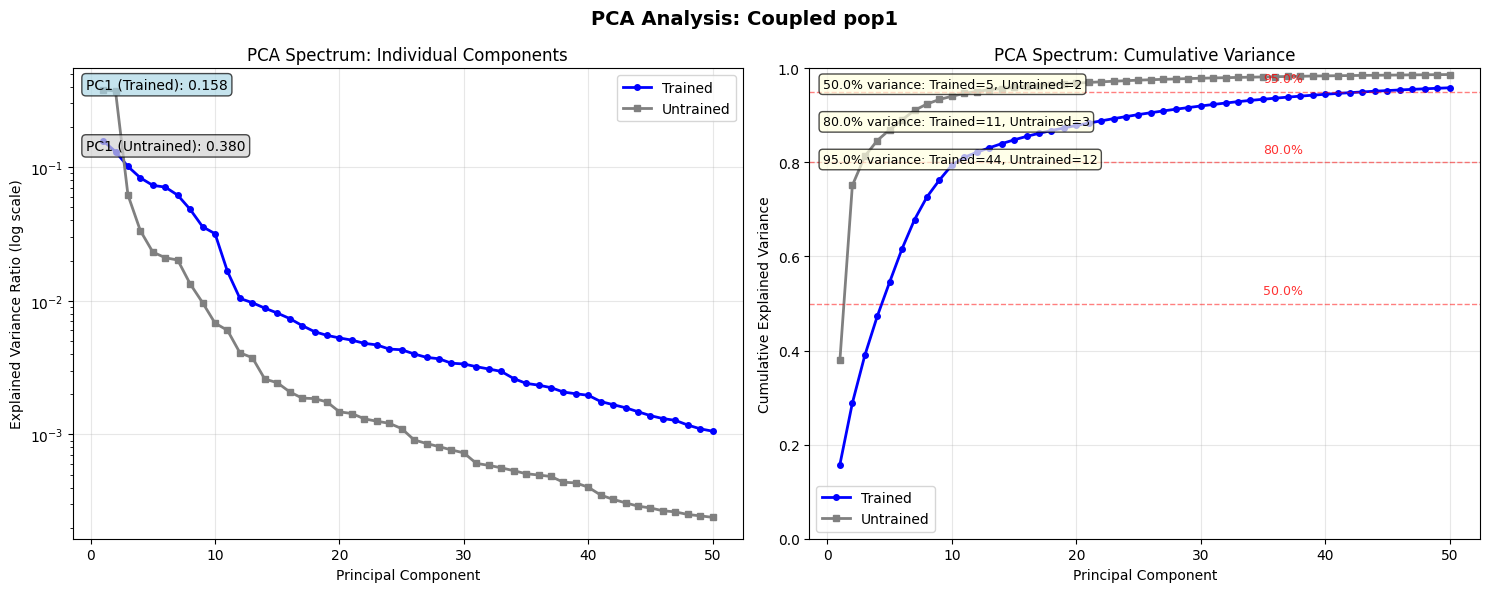


=== PCA Spectrum Analysis for Coupled pop1 ===
First 10 components (Trained):   [0.1577612  0.13057957 0.10120363 0.08318905 0.07307336 0.07091466
 0.0617213  0.04831699 0.03583392 0.03175794]
First 10 components (Untrained): [0.3798697  0.3712268  0.06191719 0.03342769 0.02314533 0.02099504
 0.02019319 0.0133803  0.00968296 0.00680121]

Variance explained by first N components:
   1 components: Trained=0.158, Untrained=0.380
   2 components: Trained=0.288, Untrained=0.751
   5 components: Trained=0.546, Untrained=0.870
  10 components: Trained=0.794, Untrained=0.941
  20 components: Trained=0.878, Untrained=0.969

Effective dimensionality (95% variance):
  Trained:   44 components
  Untrained: 12 components

First PC dominance:
  Trained PC1 explains 15.8% of variance
  Untrained PC1 explains 38.0% of variance
  → Trained model shows structured low-dimensional dynamics
  → Untrained model shows some structure (unexpected)


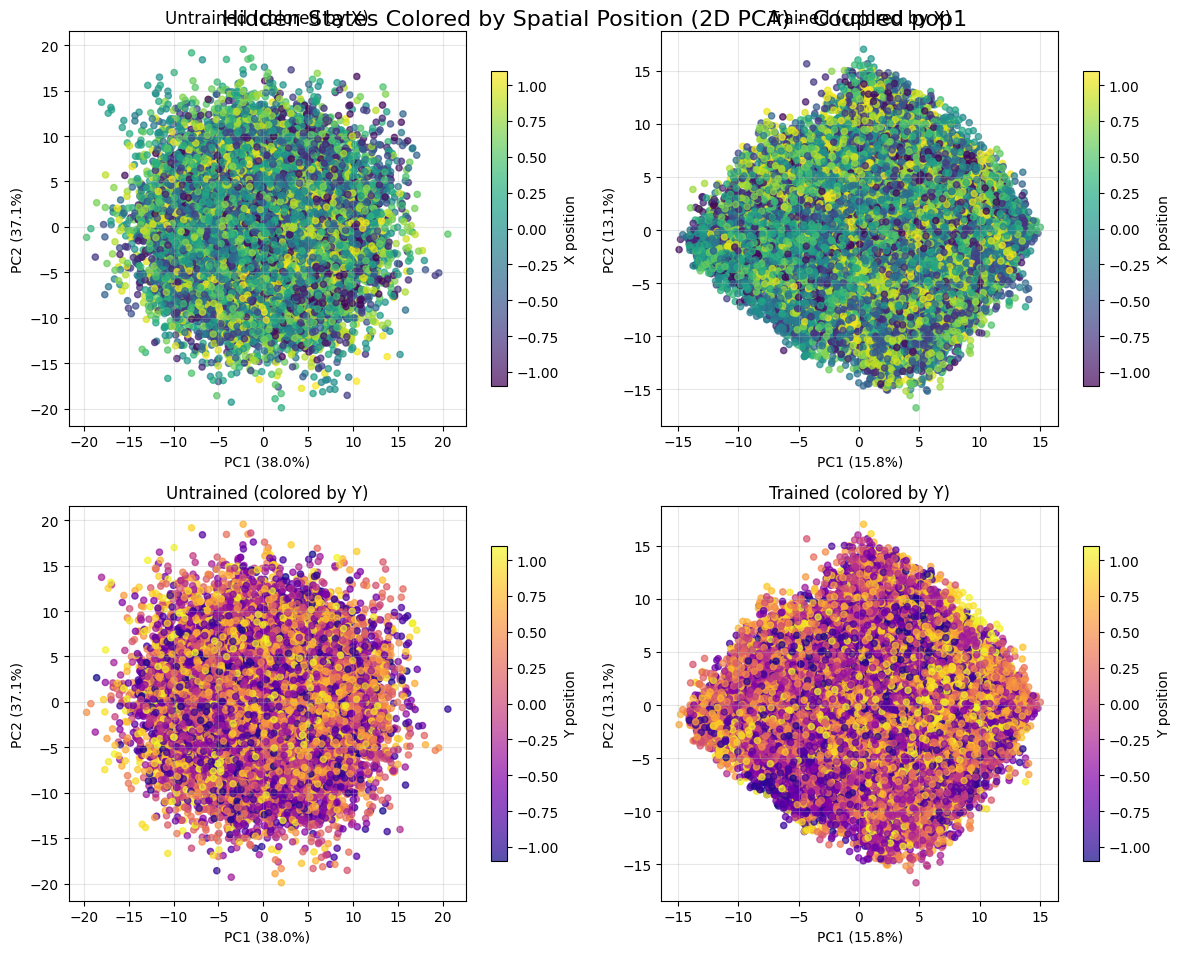

In [8]:
from pirnns.analysis.dynamics import DynamicsAnalyzer

if model_type == "vanilla":
    from pirnns.rnns.rnn import RNN
    import torch.nn as nn

    untrained_model = RNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["num_place_cells"],
        alpha=config["alpha"],
        activation=getattr(nn, config["activation"]),
    )
elif model_type == "coupled":
    from pirnns.rnns.coupled_rnn import CoupledRNN
    import torch.nn as nn

    untrained_model = CoupledRNN(
        input_size=config["input_size"],
        pop1_size=config["pop1_size"],
        pop2_size=config["pop2_size"],
        output_size=config["num_place_cells"],
        alpha1=config["alpha1"],
        alpha2=config["alpha2"],
        activation=getattr(nn, config["activation"]),
        output_from=config["output_from"],
    )

untrained_model.to(device)
untrained_model.eval()

dynamics = (
    DynamicsAnalyzer(
        trained_model=model,
        untrained_model=untrained_model,
        device=device,
        model_type=model_type,
        population_to_visualize="pop1",
    )
    .compute_hidden_states(eval_loader=eval_loader, num_batches=1000)
    .compute_pca(n_components=100)
    .plot_pca_spectrum()
    .plot_2d_pca_trajectories()
)